In [11]:
import os
import torch
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from segment_anything import SamPredictor, sam_model_registry
from groundingdino.util.inference import Model as GroundingDINOModel
import supervision as sv

In [12]:
SAM_CHECKPOINT_PATH = "sam_vit_b_01ec64.pth"
DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
DINO_CHECKPOINT_PATH = "groundingdino_swint_ogc.pth"
IMAGE_PATH = "data/test_image3.tif"

SAM_MODEL_TYPE = "vit_b"
TEXT_PROMPTS = ["tree", "house"]
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using: {DEVICE}")

using: cuda


In [14]:
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"loading {filename}...")
        try:
            r = requests.get(url, allow_redirects=True)
            r.raise_for_status()
            with open(filename, 'wb') as f:
                f.write(r.content)
            print(f"{filename} Loaded.")
        except Exception as e:
            print(f"Error {filename}: {e}")

download_file("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth", SAM_CHECKPOINT_PATH)
download_file("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth", DINO_CHECKPOINT_PATH)

In [15]:
if not os.path.exists("GroundingDINO"):
    !git clone https://github.com/IDEA-Research/GroundingDINO.git

In [16]:
grounding_dino_model = GroundingDINOModel(
    model_config_path=DINO_CONFIG_PATH,
    model_checkpoint_path=DINO_CHECKPOINT_PATH,
    device=DEVICE
)

sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


In [17]:
try:
    with rasterio.open(IMAGE_PATH) as src:
        image_data = src.read([1, 2, 3])
        image_rgb = np.moveaxis(image_data, 0, -1)

        if image_rgb.dtype == 'uint16':
            image_rgb = (image_rgb / 256).astype('uint8')
        elif image_rgb.dtype != 'uint8':
             image_rgb = image_rgb.astype('uint8')

    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

except Exception as e:
    print(f"Error {IMAGE_PATH}: {e}")

Found  5 objects.


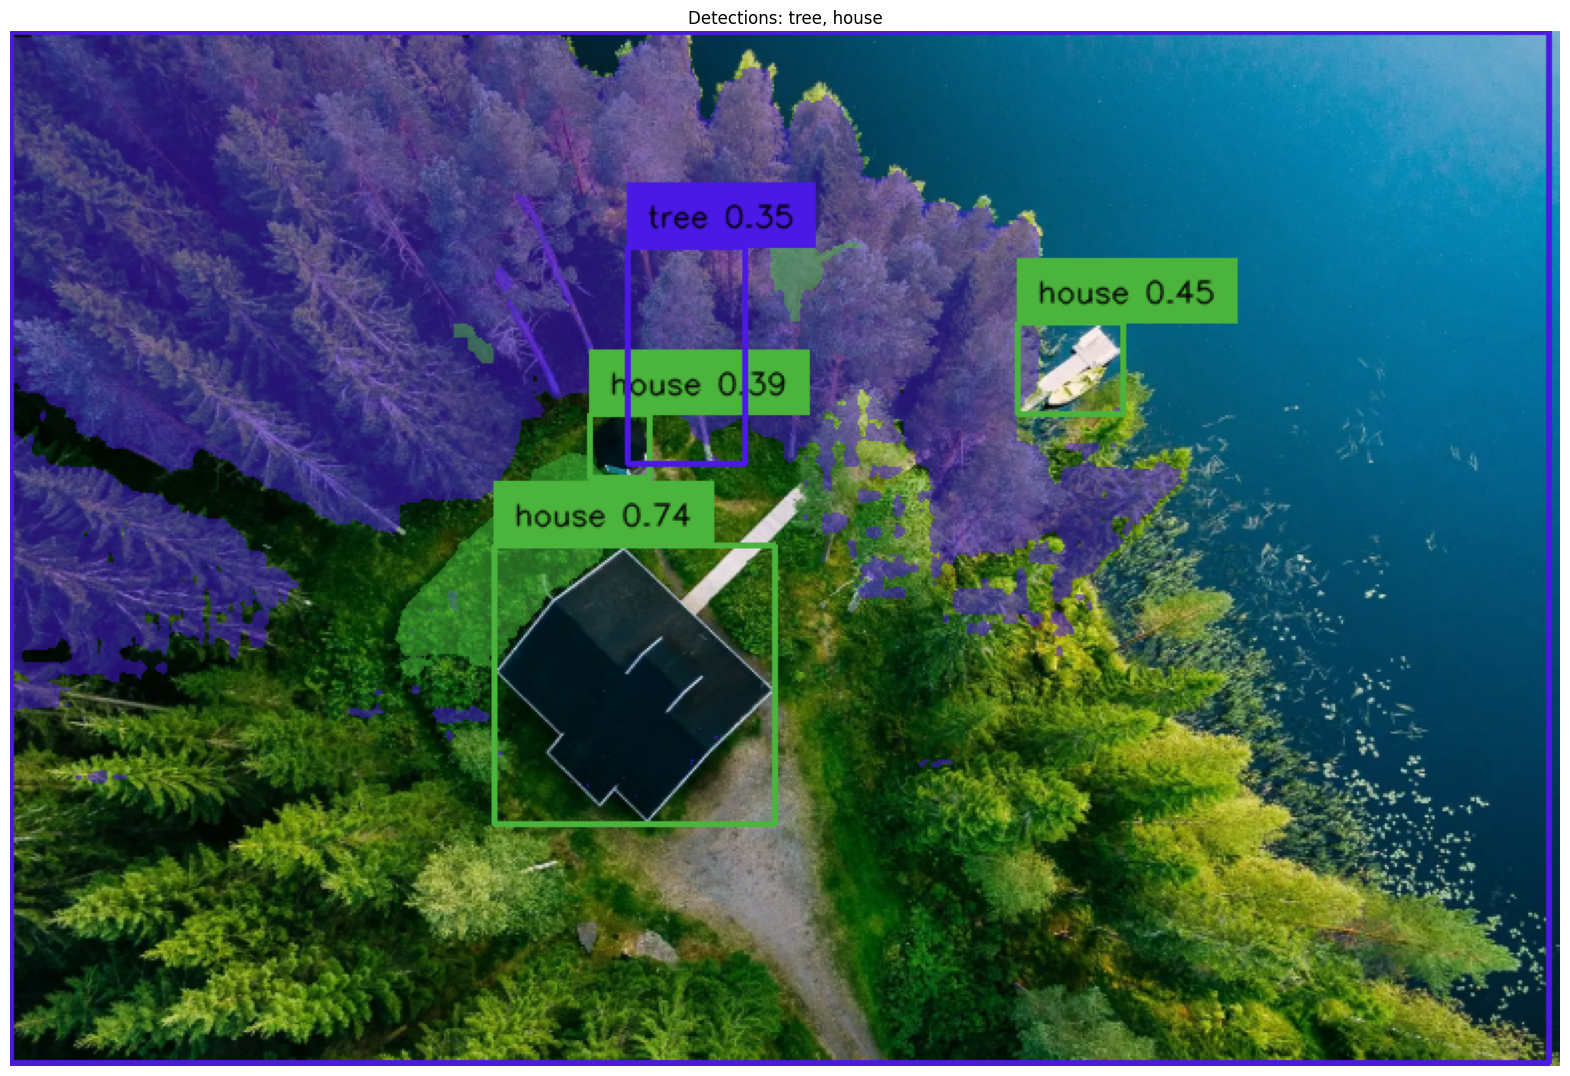

In [18]:
if 'image_rgb' in locals():
    detections = grounding_dino_model.predict_with_classes(
        image=image_rgb,
        classes=TEXT_PROMPTS,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    print(f"Found  {len(detections)} objects.")

    if len(detections) > 0:
        sam_predictor.set_image(image_rgb)

        masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=torch.tensor(detections.xyxy, device=DEVICE),
            multimask_output=False,
        )

        detections.mask = masks.squeeze(1).cpu().numpy()
        #Visualize
        box_annotator = sv.BoxAnnotator()
        mask_annotator = sv.MaskAnnotator()

        labels = [
            f"{TEXT_PROMPTS[detections.class_id[i]]} {detections.confidence[i]:.2f}"
            for i in range(len(detections))
        ]

        annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

        plt.figure(figsize=(20, 15))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title(f"Detections: {', '.join(TEXT_PROMPTS)}")
        plt.show()

    else:
        print("No objects found.")


In [19]:
if 'detections' in locals() and 'image_rgb' in locals():

    np.save('output_image_rgb.npy', image_rgb)

    np.save('output_masks.npy', detections.mask)

    np.save('output_class_ids.npy', detections.class_id)